**Import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

**Import data**

In [2]:
def dataset(file): 
    # Read csv file 
    df = pd.read_csv(file)
    
    # Drop columns that relates to ID 
    columns_to_drop = ["Y1", "YY1", "EMERGPSTP"]
    
    cols = []
    # Statistics of missing values 
    for col in df.columns:
        # Calculate the missing value in % 
        missing_percent = df[col].isna().mean() * 100

        # Append column to columns_to_drop if missing value is less than 5% 
        if (missing_percent > 0) & (missing_percent < 5):
                cols.append(col)
    
    # Drop rows where NAs exists 
    df.dropna(subset=cols, inplace=True)
    
    # Drop columns     
    df.drop(columns = [x for x in columns_to_drop if x in df.columns], inplace=True)
    
    return df

In [3]:
# Read train data
df = dataset("SCFP2019.csv")

pd.set_option("display.max_columns", None) # Show all columns

In [4]:
# Identify predictors and target
X = df.loc[:, df.columns != "TURNDOWN"]
y = df["TURNDOWN"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

In [5]:
xgbc = XGBClassifier(random_state=111)
boruta_selector = BorutaPy(xgbc, n_estimators='auto', verbose=2, random_state=111)
boruta_selector.fit(np.array(X_train), np.array(y_train)) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	347
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	80
Rejected: 	267
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	70
Rejected: 	267
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	70
Rejected: 	267
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	70
Rejected: 	267
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	58
Rejected: 	279
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	58
Rejected: 	279
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	58
Rejected: 	279
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	58
Rejected: 	279
Iteration: 	16 / 100
Confirmed: 	1

BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bynode=1, colsample_bytree=1,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 gamma=0, gpu_id=-1, grow_policy='depthwise',
                                 importance_type=None,
                                 interaction_constraints='',
                                 learning_rate=0.300000012, max_bin=256,
                                 max_cat_to_onehot=4, max_delta_step=0,
                                 max_depth=6, max_leaves=0, min_child_weight=1,
                                 missing=nan, monotone_constraints='()',
                                 n_estimators=131, n_jobs=0,
                                 num_parallel_tree=1, predictor='auto',
                                 random_state=1237492798, reg_alpha=0,
                                 reg_lambda=1, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x29BB762F740, verbose=2)

In [6]:
# Subset train and test dataset
X_train_boruta = X_train[X_train.columns[boruta_selector.support_]]
X_test_boruta = X_test[X_test.columns[boruta_selector.support_]]

In [8]:
# Correlation matrix 
corr = X_train_boruta.corr()

# Keep upper part of correlation matrix
corr_upper = corr.where(np.triu(np.ones(corr.abs().shape),k=1).astype(np.bool_))

# Drop variables with correlation greater than 0.70
to_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.70)]

In [9]:
# Filter out columns with correlation greater than 0.70
X_train_boruta = X_train_boruta.loc[:, ~X_train_boruta.columns.isin(to_drop)].copy()
X_test_boruta = X_test_boruta.loc[:, ~X_test_boruta.columns.isin(to_drop)].copy()

In [23]:
X_train_boruta.columns

Index(['INDCAT', 'LATE60', 'CRDAPP', 'FEARDENIAL', 'EMERGCUT', 'CKRECOMFRND',
       'CKPERSONAL', 'STOCKS', 'NSTOCKS', 'FUTPEN', 'BPLANCJ', 'SAVBND',
       'NNRESRE', 'MORT1', 'LLOAN4'],
      dtype='object')

In [10]:
# Oversample target variable to ensure data balance in target variable 
OS = SMOTE(random_state=111)
X_train_OS, y_train_OS = OS.fit_resample(X_train_boruta, y_train)

In [11]:
# Hyperparameter tuning 
params = {"n_estimators": range(25, 175, 25), 
          "max_depth": range(1, 10, 1),
          "min_child_weight": range(1, 10, 1), 
          "gamma": np.arange(1, 15, 1),
          "reg_alpha": [0.5, 1, 3, 5, 10], 
          "reg_lambda": [0.5, 1, 3, 5, 10]}
    
# Search for best hyperparameters
rs_model = RandomizedSearchCV(estimator=xgbc, 
                          param_distributions=params, 
                          verbose=1, 
                          cv=10) 

# Fit model
rs_model.fit(X_train_OS, y_train_OS)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256...
                                           monotone_constraints='()',
                                           n_estimators=131, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto',
                                           random_state=210024489, reg_alpha=0,
                                           reg_lambda=1, ...),
                   param_distributions={'gamma': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'max_depth': range(1, 10),
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': range(25, 175, 25),
                                        'reg_alpha': [0.5, 1, 3, 5, 10],
                                        'reg_lambda': [0.5, 1, 3, 5, 10]},
                   verbose=1)

In [12]:
# Train
actual_train, predicted_train = y_train_OS, rs_model.predict(X_train_OS) 
accuracy_train = accuracy_score(y_train_OS, rs_model.predict(X_train_OS))
tn_train, fp_train, fn_train, tp_train = confusion_matrix(actual_train, predicted_train).ravel()
sensitivity_train = tp_train/(tp_train+fn_train)
specificity_train = tn_train/(tn_train+fp_train)

# Test
actual_test, predicted_test = y_test, rs_model.predict(X_test_boruta) 
accuracy_test = accuracy_score(y_test, rs_model.predict(X_test_boruta))
tn_test, fp_test, fn_test, tp_test = confusion_matrix(actual_test, predicted_test).ravel()
sensitivity_test = tp_test/(tp_test+fn_test)
specificity_test = tn_test/(tn_test+fp_test)

print(f'Accuracy train: {accuracy_train:.2f}')
print(f'Sensitivity train: {sensitivity_train:.2f}')
print(f'Specificity test: {specificity_train:.2f}')
print(f'Accuracy test: {accuracy_test:.2f}')
print(f'Sensitivity test: {sensitivity_test:.2f}')
print(f'Specificity test: {specificity_train:.2f}')

Accuracy train: 0.87
Sensitivity train: 0.98
Specificity test: 0.77
Accuracy test: 0.77
Sensitivity test: 0.94
Specificity test: 0.77


In [21]:
rs_model.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 1,
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 8,
 'gamma': 7}

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


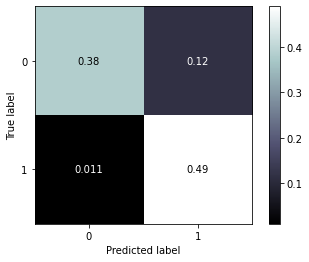

In [13]:
# Plot confusion matrix
plot_confusion_matrix(rs_model, X_train_OS, y_train_OS, normalize='all', cmap='bone')  
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


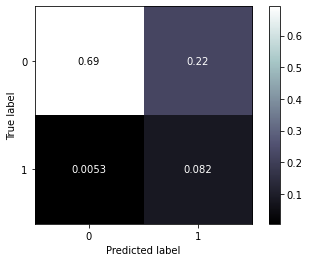

In [14]:
# Plot confusion matrix
plot_confusion_matrix(rs_model, X_test_boruta, y_test, normalize='all', cmap='bone')  
plt.show()

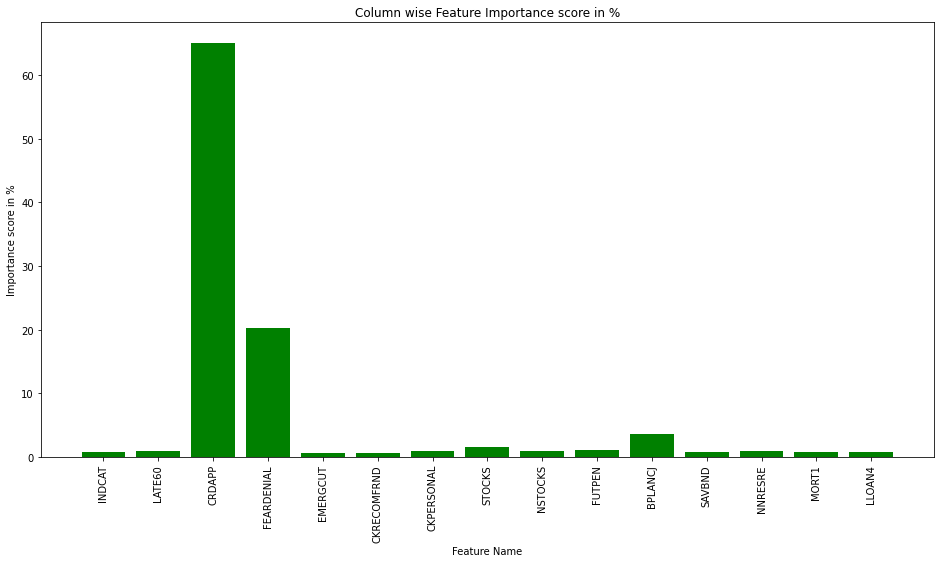

In [15]:
# Variable importance
importance = rs_model.best_estimator_.feature_importances_

# plot feature importance
plt.figure(figsize=(16,8))
plt.bar(X_test_boruta.columns, [i*100 for i in importance], color='green')
plt.title('Column wise Feature Importance score in %')
plt.xlabel('Feature Name')
plt.ylabel('Importance score in %')
plt.xticks(rotation=90)
plt.show()

In [16]:
explainer = shap.Explainer(rs_model.best_estimator_)
shap_values = explainer(X_test_boruta)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


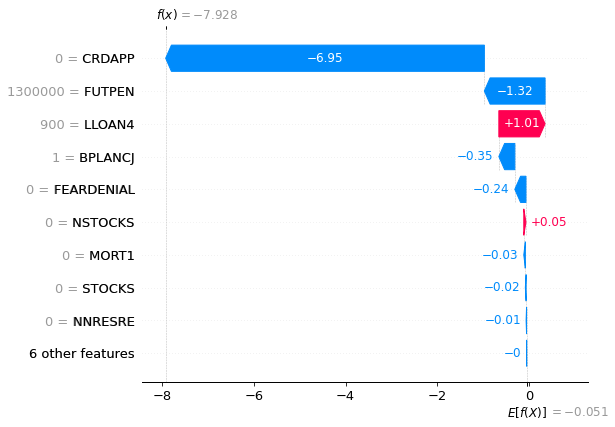

In [17]:
# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

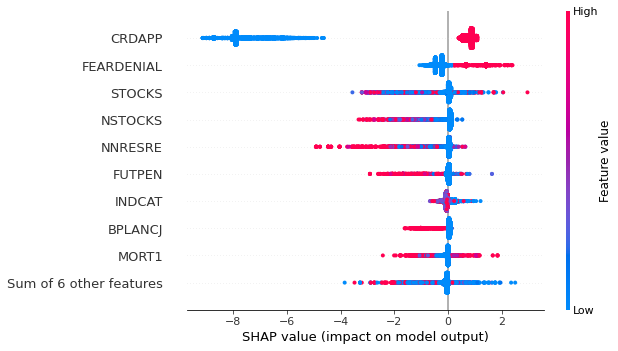

In [18]:
# Top features and its impact on TURNFEAR 
shap.plots.beeswarm(shap_values)